In [1]:
#@Title Import dependencies 

# Machine leaning
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data analysis
import os
import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request
import zipfile
import shutil

In [2]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# 3
# Rescale pixel values from [0, 255] to [0, 1] / normalizing to binary
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# create a subfolder for the test images
dst_dir = os.path.join(test_dir, 'test_img')
os.makedirs(dst_dir, exist_ok=True)

# move all the test images to the new folder
for file in os.listdir(test_dir):
    if file.lower().endswith('.jpg'):
        shutil.move(os.path.join(test_dir, file), os.path.join(dst_dir, file))

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size = ((IMG_HEIGHT, IMG_WIDTH)),
    batch_size = batch_size,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size = ((IMG_HEIGHT, IMG_WIDTH)),
    batch_size = batch_size,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size = ((IMG_HEIGHT, IMG_WIDTH)),
    batch_size = batch_size,
    class_mode= None,
    shuffle = False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


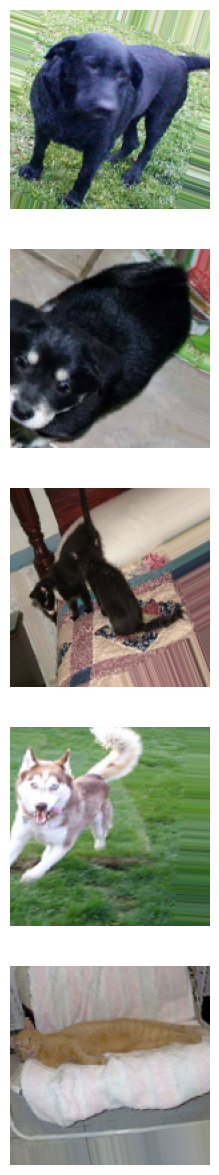

In [35]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))

    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [5]:
# 5
# generate more training data from existing training
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Randomly rotate images (0 to 40 degrees)
    width_shift_range=0.2,      # Randomly shift images horizontally (20%)
    height_shift_range=0.2,     # Randomly shift images vertically (20%)
    shear_range=0.2,            # Random shear transformation
    zoom_range=0.2,             # Random zoom in/out
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after rotation/shift
)



Found 2000 images belonging to 2 classes.


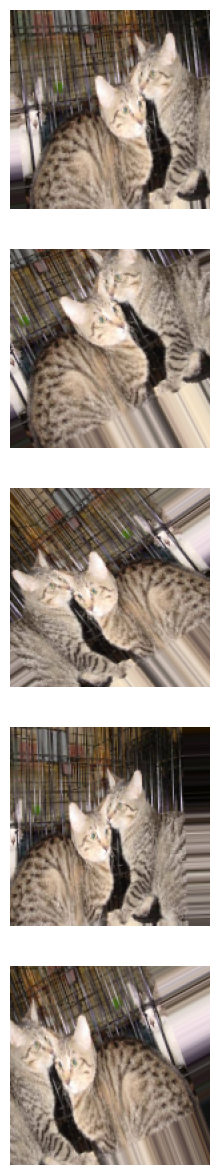

In [36]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 8

history = model.fit(
    x=train_data_gen,
    steps_per_epoch=100,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=50
)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7188 - loss: 0.5438 - val_accuracy: 0.7240 - val_loss: 0.5244
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7161 - loss: 0.5566 - val_accuracy: 0.6950 - val_loss: 0.5587
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7126 - loss: 0.5668 - val_accuracy: 0.7280 - val_loss: 0.5264
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7200 - loss: 0.5458 - val_accuracy: 0.7290 - val_loss: 0.5264
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7080 - loss: 0.5631 - val_accuracy: 0.7030 - val_loss: 0.5508
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7282 - loss: 0.5509 - val_accuracy: 0.7280 - val_loss: 0.5266
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7109 - loss: 0.5448 - val_accuracy: 0.7370 - val_loss: 0.5127
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7223 - loss: 0.5369 - val_ac

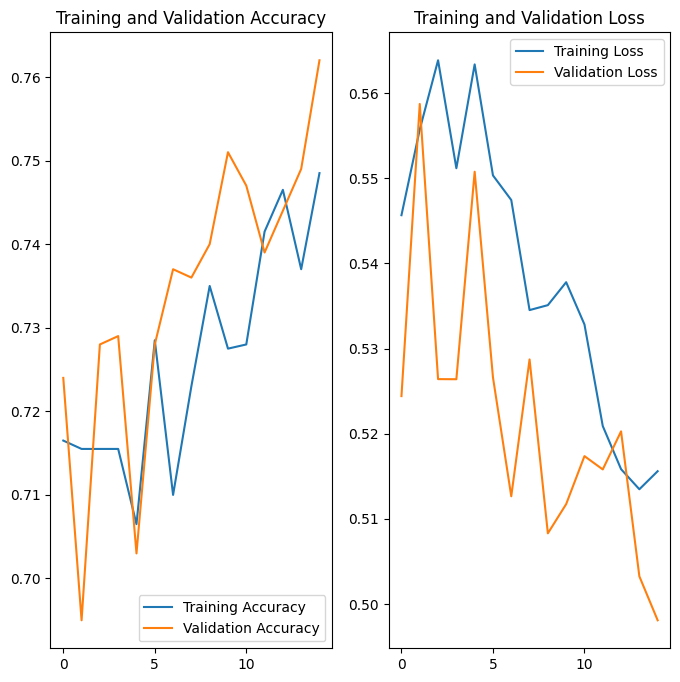

In [12]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
# 10
test_img = next(test_data_gen)
probabilities = model.predict(test_img)
probabilities = probabilities.flatten()
# probabilities = [int(prob[0] > 0.5) for prob in probabilities]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


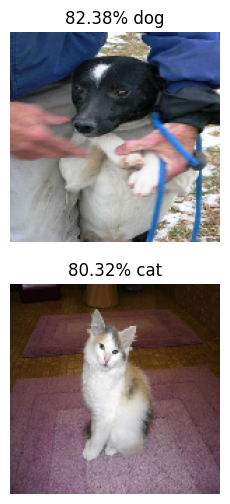

In [51]:
plotImages(test_img[:2], probabilities[:2])

In [52]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
